# Projet Science des données: Prédiction de sinistres automobiles

Ce notebook implémente les étapes d'un projet de classification supervisée:
- Importation des données
- Exploration et examen des données
- Préparation et prétraitement
- Analyse des corrélations
- Séparation jeux d'apprentissage et test
- Entraînement de modèles (régression logistique)
- Évaluation et validation croisée
- Comparaison de plusieurs classifieurs
- Sauvegarde du meilleur modèle

# 0. Important des librairies

In [68]:
# Importation des librairies utilisées pour le projet
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np; np.seterr(divide='ignore', over='ignore', invalid='ignore')
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pickle

# 1. Importation des données

In [69]:
df = pd.read_csv('data/car_insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


# 2. Examen des données

In [70]:
print(f"Nombre de lignes : {df.shape[0]} et nombre de colonnes : {df.shape[1]}")

Nombre de lignes : 10000 et nombre de colonnes : 18


## Valeurs Manquantes

In [71]:
for column in df.columns:
    print(f'{column} : {df[column].isnull().sum()}')

id : 0
age : 0
gender : 0
driving_experience : 0
education : 0
income : 0
credit_score : 982
vehicle_ownership : 0
vehicle_year : 0
married : 0
children : 0
postal_code : 0
annual_mileage : 957
vehicle_type : 0
speeding_violations : 0
duis : 0
past_accidents : 0
outcome : 0


## Valeurs prise par colonnes

In [72]:
for column in df.columns.tolist():
    print(column)
    print(df[column].value_counts())
    print("---------------------------------")

id
id
569520    1
702473    1
426507    1
386239    1
454670    1
         ..
931908    1
672440    1
297005    1
559584    1
442696    1
Name: count, Length: 10000, dtype: int64
---------------------------------
age
age
1    3063
2    2931
0    2016
3    1990
Name: count, dtype: int64
---------------------------------
gender
gender
0    5010
1    4990
Name: count, dtype: int64
---------------------------------
driving_experience
driving_experience
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64
---------------------------------
education
education
high school    4157
university     3928
none           1915
Name: count, dtype: int64
---------------------------------
income
income
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64
---------------------------------
credit_score
credit_score
0.629027    1
0.618094    1
0.396540    1
0.578306    1
0.633275    1
           ..
0.309272    1
0

In [73]:
print(df.describe())

                  id           age        gender  credit_score  \
count   10000.000000  10000.000000  10000.000000   9018.000000   
mean   500521.906800      1.489500      0.499000      0.515813   
std    290030.768758      1.025278      0.500024      0.137688   
min       101.000000      0.000000      0.000000      0.053358   
25%    249638.500000      1.000000      0.000000      0.417191   
50%    501777.000000      1.000000      0.000000      0.525033   
75%    753974.500000      2.000000      1.000000      0.618312   
max    999976.000000      3.000000      1.000000      0.960819   

       vehicle_ownership       married      children   postal_code  \
count       10000.000000  10000.000000  10000.000000  10000.000000   
mean            0.697000      0.498300      0.708600  19864.548400   
std             0.459578      0.500022      1.350433  18915.613855   
min             0.000000      0.000000      0.000000  10238.000000   
25%             0.000000      0.000000      0.000000  1

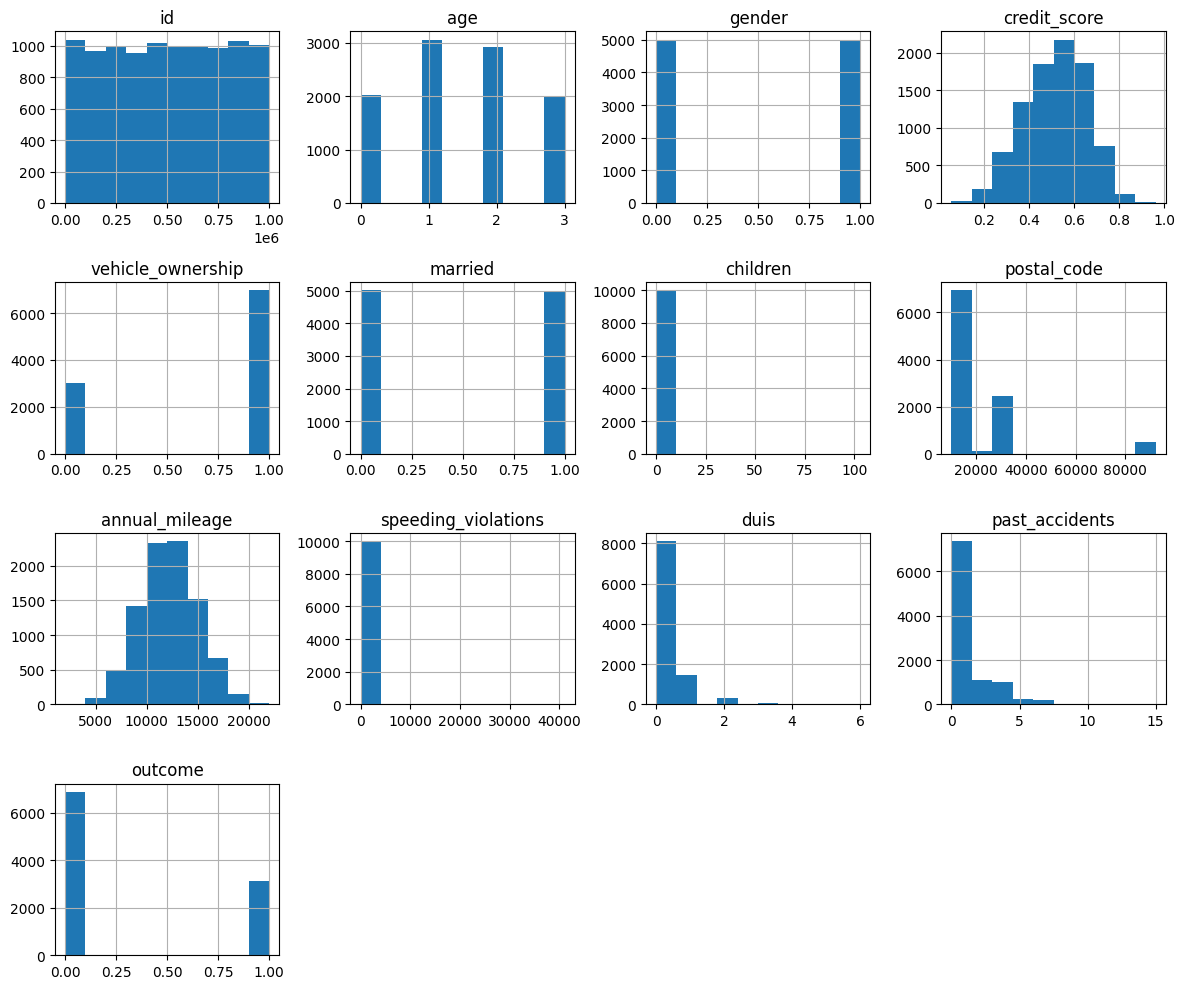

In [74]:
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# 3.Préparation des données

## Suppression des colonnes inutiles

In [75]:
# Suppression de la colonne 'id', aléatoire et sans utilité pour l'apprentissage du modèle
df.drop(['id', 'postal_code'], axis=1, inplace=True)

## Données aberrantes

#### Children

In [76]:
# Valeurs disponibles de children
df['children'].value_counts()
db.sql("SELECT * FROM df WHERE children > 10").df()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,0,0,0-9y,none,poverty,0.186185,0.0,before 2015,0.0,103.0,17000.0,sedan,0,0,0,1.0
1,1,0,0-9y,none,poverty,0.207650,0.0,before 2015,1.0,24.0,11000.0,sedan,0,0,0,1.0
2,0,1,0-9y,none,poverty,0.209536,0.0,before 2015,1.0,72.0,14000.0,sedan,0,0,0,1.0


In [77]:
# Rectification des données aberrantes (plus de 10 enfants) de la colonne children par la mediane
df.loc[df['children'] > 10, 'children'] = df.loc[df['children'] <= 10, 'children'].median()

#### Speeding Violations

In [78]:
# Rectification des données aberrantes comptabilisant plus de 1000 excès de vitesse dans la colonne speeding_violations par la médiane.
df.loc[df['speeding_violations'] > 50, 'speeding_violations'] = df.loc[df['speeding_violations'] < 50, 'speeding_violations'].median()

## Données manquantes

In [79]:
for column in df.columns.tolist():
    if df[column].isna().mean() > 0.3:
        # Supprime la colonne si elle contient plus de 30% de données N/A
        df.drop([column], axis=1, inplace=True)
    elif df[column].dtype == 'int64':
        # Remplace les N/A par la médiane
        df[column] = df[column].fillna(df[column].median())
    elif df[column].dtype == 'float64':
        # Remplace les N/A par la moyenne
        df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtype == 'object':
        # Remplace les N/A par la valeur la plus fréquente
        most_frequent_value = df[column].mode(dropna=True)[0]
        df[column] = df[column].fillna(most_frequent_value)


## Transformation des variables qualitatives en variables numeriques :

In [80]:
encoders, mappings = {}, {}
for col in df.select_dtypes('object'):
    le = LabelEncoder().fit(df[col].astype(str))
    df[col] = le.transform(df[col].astype(str))
    encoders[col] = le
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

## Normalisation des données

In [81]:
target = 'outcome'
features = df.columns.tolist()
features.remove(target)
scaler = StandardScaler().set_output(transform="pandas")
df[features] = scaler.fit_transform(df[features])


# 4.Recherche de corrélation

Corrélation avec 'outcome' :
 outcome                1.000000
vehicle_year           0.294178
annual_mileage         0.177575
gender                 0.107208
vehicle_type           0.005620
income                -0.047560
education             -0.092643
duis                  -0.189352
children              -0.232237
married               -0.261807
speeding_violations   -0.291862
credit_score          -0.309010
past_accidents        -0.311495
vehicle_ownership     -0.378921
age                   -0.448463
driving_experience    -0.497431
Name: outcome, dtype: float64


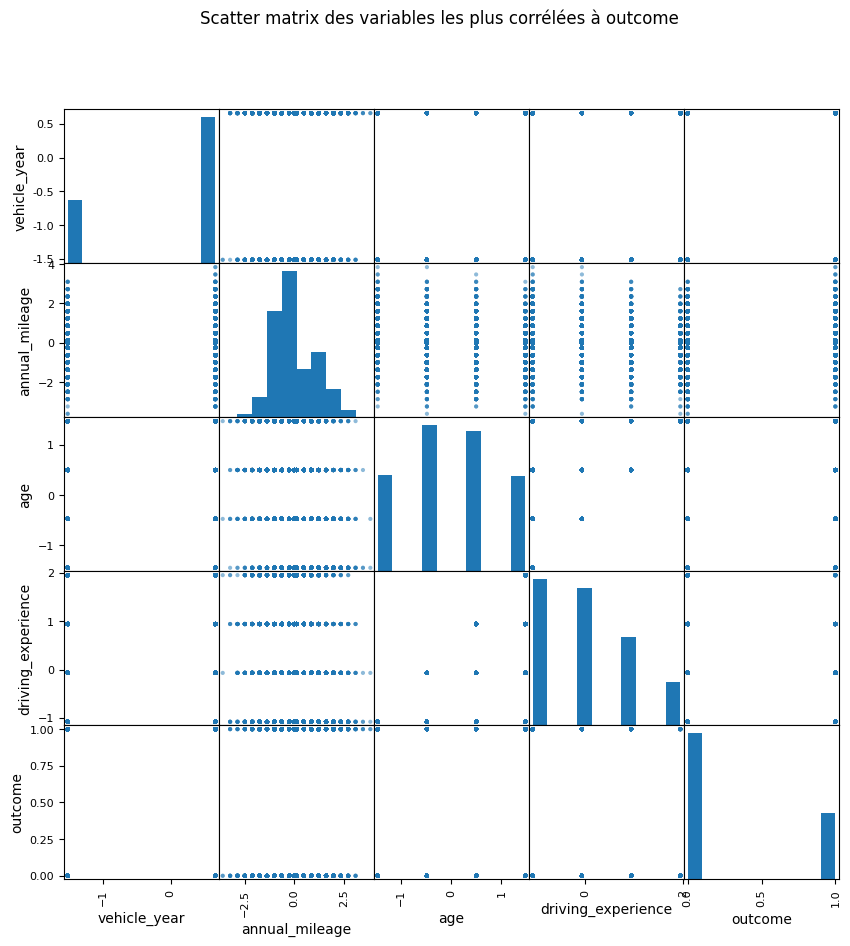

In [82]:
df_corr = df.copy()
corr_matrix = df_corr.corr()
corr_with_target = corr_matrix['outcome'].sort_values(ascending=False)
print("Corrélation avec 'outcome' :\n", corr_with_target)

# Utilisation des top_features pour la visualisation des corrélations
top_features = corr_with_target.index[1:3].tolist() + corr_with_target.index[-2:].tolist()
scatter_matrix(df_corr[top_features + ['outcome']], figsize=(10, 10))

# Affichage du graphe
plt.suptitle("Scatter matrix des variables les plus corrélées à outcome")
plt.show()

# 5.Extraction des jeux d’apprentissage et de test

In [83]:
# Séparation des variables explicatives (X) et de la variable cible (y)
X = df.drop(columns='outcome').values
y = df['outcome'].values

# Division en jeux d'entraînement (75%) et de test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

total = len(df)
print(f"Taille totale : {total} exemples")
print(f"Jeu d'entraînement : {len(X_train)} exemples ({len(X_train)/total:.2%})")
print(f"Jeu de test : {len(X_test)} exemples ({len(X_test)/total:.2%})")

Taille totale : 10000 exemples
Jeu d'entraînement : 7500 exemples (75.00%)
Jeu de test : 2500 exemples (25.00%)


# 6.Entraînement d'un modèle

In [84]:
model_logistic_regression = LogisticRegression(
    random_state=42
)

# Optimisation du modèle
gs = GridSearchCV(model_logistic_regression,
                  {'C':[0.01,0.1,1,10,100], 'penalty':['l1','l2'], 'solver':['liblinear'], 'max_iter':[100,500,1000]},
                  cv=5).fit(X, y)
model_logistic_regression = LogisticRegression(**gs.best_params_, random_state= 42)

# Entraînement du modèle
model_logistic_regression.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

# 7.Evaluation du modèle

In [85]:
# Prédiction du modèle
y_predict_test = model_logistic_regression.predict(X_test)

In [86]:
for i in range(len(X_test)):
    print(f'{y_test[i]} : {y_predict_test[i]} ')

1.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 1.0 
1.0 : 1.0 
1.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 1.0 
1.0 : 0.0 
0.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 

In [87]:
def classification_metrics(y_true, y_pred):
    return {
        'accuracy':         accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'precision':        precision_score(y_true, y_pred),
        'recall':           recall_score(y_true, y_pred),
        'f1_score':         f1_score(y_true, y_pred),
    }

y_pred = model_logistic_regression.predict(X_test)
metrics_logistic_regression = classification_metrics(y_test, y_pred)

print(f"Accuracy {metrics_logistic_regression['accuracy']:.4f}")
print("Matrice de confusion :")
print(metrics_logistic_regression['confusion_matrix'])
print(f"Precision : {metrics_logistic_regression['precision']:.4f}")
print(f"Recall : {metrics_logistic_regression['recall']:.4f}")
print(f"F1 Score : {metrics_logistic_regression['f1_score']:.4f}")

Accuracy 0.8440
Matrice de confusion :
[[1556  167]
 [ 223  554]]
Precision : 0.7684
Recall : 0.7130
F1 Score : 0.7397


# 8.Amélioration de l’évaluation

In [88]:
def evaluate_model(model, n_split, random_state, X, y):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=random_state)
    metrics = {
        'accuracy':cross_val_score(model, X, y, cv=kf, scoring='accuracy'),
        'precision':cross_val_score(model, X, y, cv=kf, scoring='precision'),
        'recall':cross_val_score(model, X, y, cv=kf, scoring='recall'),
        'f1_score':cross_val_score(model, X, y, cv=kf, scoring='f1'),
    }
    for metric_name, scores in metrics.items():
        print(f"{metric_name.capitalize():<10} : Moyenne = {np.mean(scores):.4f} |  Écart-type = {np.std(scores):.4f}")
    return metrics

metrics_logistic_regression = evaluate_model(model_logistic_regression, 5, 42, X, y)

Accuracy   : Moyenne = 0.8400 |  Écart-type = 0.0052
Precision  : Moyenne = 0.7574 |  Écart-type = 0.0155
Recall     : Moyenne = 0.7206 |  Écart-type = 0.0156
F1_score   : Moyenne = 0.7383 |  Écart-type = 0.0081


# 9.Comparaison avec d’autres algorithmes

## Perceptron

In [89]:
print('Avec les paramètres par défaut')
model_perceptron = Perceptron(random_state=42)
metrics_perceptron = evaluate_model(model_perceptron, 5, 42, X, y)

print('Avec des paramètres personnalisées')
# Optimisation du modèle
gs = GridSearchCV(
    model_perceptron,
    {'eta0': [0.001, 0.01, 0.1,1], 'max_iter': [100, 500, 1000], 'penalty': [None, 'l2', 'l1','elasticnet']},
    cv=5
).fit(X, y)

model_perceptron = Perceptron(**gs.best_params_, random_state= 42)
metrics_perceptron = evaluate_model(model_perceptron, 5, 42, X, y)

Avec les paramètres par défaut
Accuracy   : Moyenne = 0.7748 |  Écart-type = 0.0153
Precision  : Moyenne = 0.6504 |  Écart-type = 0.0314
Recall     : Moyenne = 0.6166 |  Écart-type = 0.1015
F1_score   : Moyenne = 0.6274 |  Écart-type = 0.0534
Avec des paramètres personnalisées
Accuracy   : Moyenne = 0.7852 |  Écart-type = 0.0192
Precision  : Moyenne = 0.6683 |  Écart-type = 0.0679
Recall     : Moyenne = 0.6763 |  Écart-type = 0.1127
F1_score   : Moyenne = 0.6602 |  Écart-type = 0.0362


## Les K plus proches voisins

In [90]:
print('Avec les paramètres par défaut')
model_kneighbors = KNeighborsClassifier()
metrics_kneighbors = evaluate_model(model_kneighbors, 5, 42, X, y)

print('Avec des paramètres personnalisées')

# Optimisation du modèle
gs = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': list(range(1, 50)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    cv=5
).fit(X, y)

model_kneighbors = KNeighborsClassifier(**gs.best_params_)
metrics_kneighbors = evaluate_model(model_kneighbors, 5, 42, X, y)

Avec les paramètres par défaut
Accuracy   : Moyenne = 0.8045 |  Écart-type = 0.0071
Precision  : Moyenne = 0.6985 |  Écart-type = 0.0102
Recall     : Moyenne = 0.6623 |  Écart-type = 0.0192
F1_score   : Moyenne = 0.6797 |  Écart-type = 0.0107
Avec des paramètres personnalisées
Accuracy   : Moyenne = 0.8304 |  Écart-type = 0.0026
Precision  : Moyenne = 0.7365 |  Écart-type = 0.0160
Recall     : Moyenne = 0.7152 |  Écart-type = 0.0125
F1_score   : Moyenne = 0.7254 |  Écart-type = 0.0035


# 10.Sauvegarde du modèle entraîné

In [91]:
# Utilisation de pickle pour la sauvegarde du modèle
with open(r'./output/best_model.pkl', 'wb') as f:
        pickle.dump(model_logistic_regression, f)